In [1]:
import warnings
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from IPython.core.display import Math, Markdown
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

----
# Q1: Curve Fitting by Cubic Splines : (Curve Fitting Problem)
You are given the following data points:
$$
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
x & 0 & 100 & 200 & 400 & 600 & 800 & 1000 \\
\hline
f(x) & 0 & 0.82436 & 1.00000 & 0.73576 & 0.40601 & 0.19915 & 0.09158 \\
\hline
\end{array}
$$

1. Develop your own code to perform cubic spline interpolation for Natural boundary
conditions
2. Plot interpolation results on the same figure for comparison.
3. Compare your results with Spline function in matlab
4. Explain and discuss:
    - How the boundary conditions affect the spline shape.
    - Compare the behavior between spline and your code.


Bonus extra:
Discuss and Develop your own code to perform cubic spline interpolation for th following
(compare with the above):
- (b) Not-a-knot boundary conditions.
- (c) Piecewise cubic Hermite interpolation

In [2]:
q1_data = dict(
    x=np.array([ 0 ,100 ,200,400,600,800,1000 ]),
    y=np.array([ 0 ,0.82436 ,1.00000, 0.73576, 0.40601, 0.19915, 0.09158]),
)

## Solution (cubic spline interpolation for Natural boundary)

$$ f(x) = \begin{cases} s_0(x) & x \in [x_0,x_1]\\
s_1(x) & x \in [x_1,x_2] \\
s_2(x) & x \in [x_2,x_3] \\
s_3(x) & x \in [x_3,x_4] \\
s_4(x) & x \in [x_4,x_5] \\
s_5(x)& x \in [x_5,x_6]
\end{cases}$$

where:

$$ s_i(x) = a_i + b_i (x-x_i) + c_i (x-x_i)^2 + d_i (x-x_i)^3 \text{    ,} \forall i \in \{0,1,2,3,4,5\}$$


Thus, we $(4 \times 6)=24$ unknowns for $\{a_i,b_i,c_i,d_i\} \forall i \in \{0,1,2,3,4,5\}$

derivatives of $s(x)$ as follows:
$$
\begin{align}
    s_i(x)   &=a_i +b_i (x-x_i) +c_i (x-x_i)^2 +d_i (x-x_i)^3 \\
    s'_i(x)  &=     b_i         +c_i 2(x-x_i)  +d_i 3(x-x_i)^2 \\
    s''_i(x) &=                  c_i 2         +d_i 6(x-x_i) \\
    s'''_i(x)&=                                 d_i 6        \\
\end{align}
$$
For $x=x_i$
$$
\begin{align}
    s_i(x_i)   &=a_i\\
    s'_i(x_i)  &=b_i\\
    s''_i(x_i) &=2c_i\\
    s'''_i(x_i)&=d_i 6\\
\end{align}
$$
For $x=x_{i+1}$
$$
\begin{align}
    s_i(x_{i+1})   &=a_i + b_i h_i     +c_i h_i^2     +d_i h_i^3 \\
    s'_i(x_{i+1})  &=      b_i         +c_i 2h_i      +d_i 3h_i^2 \\
    s''_i(x_{i+1}) &=                   c_i 2         +d_i 6h_i \\
    s'''_i(x_{i+1})&=                                  d_i 6        \\
\end{align}
$$

In [3]:
n = len(q1_data['x']) - 1 # number of intervals
q1_unknowns = (
    [f'a_{i}' for i in range(n)]+
    [f'b_{i}' for i in range(n)]+
    [f'c_{i}' for i in range(n)]+
    [f'd_{i}' for i in range(n)]
)
q1_eqs = pd.DataFrame(columns=q1_unknowns+ ['LHS'])

In [4]:
q1_hi = np.zeros(n)
display(Markdown(r'Let $h_i = x_{i+1}-x_i$ thus:'))
for i,(xi, xip1) in enumerate(zip(q1_data['x'][:-1], q1_data['x'][1:])):
    h = xip1 - xi
    q1_hi[i] = h
    display(Math(f'h_{i} = x_{i+1}-x_{i} ={xip1}-{xi} = {h}'))

Let $h_i = x_{i+1}-x_i$ thus:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The function values must be equal at beginning of $s_i(x)$:
$$
\begin{align}
    f_{i} & = s_{i}(x_{i}) \\
    f_{i} & = a_i \\
\end{align}
$$


In [5]:
for i in range(n):
    y=q1_data['y'][i]
    display(Math(f"s_{i}(x_{i})=f_{i}"
    fr"\rightarrow a_{i} = {y}"))
    q1_eqs.loc[i,f'a_{i}'] = 1
    q1_eqs.loc[i,'LHS'] = y

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The function values must be equal at the end of $s_i(x)$:
$$
\begin{align}
    f_{i+1} & = s_{i}(x_{i+1}) \\
    f_{i+1} & = a_i + h_i b_i+ h_i^2 c_i+h_i^3 d_i
\end{align}
$$

In [6]:
for i in range(n):
    h=q1_hi[i]
    y=q1_data['y'][i+1]
    display(Math(f"s_{i}(x_{i+1})=f_{i+1}"
    fr"\rightarrow  a_{i}+{h}b_{i}+ {h**2} c_{i}+{h**3} d_{i}= {y}"))
    q1_eqs.loc[n+i,f'a_{i}'] = 1
    q1_eqs.loc[n+i,f'b_{i}'] = h
    q1_eqs.loc[n+i,f'c_{i}'] = h**2
    q1_eqs.loc[n+i,f'd_{i}'] = h**3
    q1_eqs.loc[n+i,'LHS'] = y

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The first derivatives at the interior knots must be equal:
$$
\begin{align}
    s'_{i}(x_{i+1}) &= s'_{i+1}(x_{i+1})\\
    b_i + 2h_i c_i + 3h_i^2 d_i &= b_{i+1} \\
    b_i -b_{i+1} + 2h_i c_i + 3h_i^2 d_i &=0
\end{align}
$$

In [7]:
for i in range(n-1):
    h = q1_hi[i]
    display(Math(f"s\'_{i}(x_{i})=s\'_{i-1}(x_{i})"
    fr"\rightarrow 0=b_{i} -b_{i+1} + {2*h} c_{i} + {3*h**2} d_{i}"))
    q1_eqs.loc[2*n+i,f'b_{i}'] = 1
    q1_eqs.loc[2*n+i,f'b_{i+1}'] = -1
    q1_eqs.loc[2*n+i,f'c_{i}'] = 2*h
    q1_eqs.loc[2*n+i,f'd_{i}'] = 3*h**2
    # q1_eqs.loc[2*n+i,'LHS'] = 0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Using the second derivative condition equality at the knots:
$$
\begin{align}
    s''_{i}(x_{i+1}) &= s''_{i+1}(x_{i+1})\\
    2c_i+6 h_i d_i  &= 2c_{i+1}\\
    c_i +3h_i d_i &= c_{i+1}\\
    c_i -c_{i+1}+3h_i d_i &= 0\\
\end{align}
$$

In [8]:
for i in range(n-1):
    h=q1_hi[i]
    display(Math(f"s\'\'_{i}(x_{i})=s\'\'_{i+1}(x_{i})"
    fr"\rightarrow 0=c_{i} -c_{i+1}+ {3*h} d_{i}"))
    q1_eqs.loc[3*n-1+i,f'c_{i}'] = 1
    q1_eqs.loc[3*n-1+i,f'c_{i+1}'] = -1
    q1_eqs.loc[3*n-1+i,f'd_{i}'] = 3*h
    # q1_eqs.loc[3*n-1+i,f'LHS'] = 0

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Natural conditions:-
$$ c_0 = c_{n-1} = 0 $$



In [9]:
# c_0 = 1
q1_eqs.loc[4*n-1,'c_0'] = 1
# q1_eqs.loc[4*n-1,'LHS'] = 0
# c_1 = 1
q1_eqs.loc[4*n,f'c_{n-1}'] = 1
# q1_eqs.loc[4*n,'LHS'] = 0

In [10]:
# Solve linear equations
assert q1_eqs.shape == (4*n,4*n+1), f'There needs to be {4*n} equations got {q1_eqs.shape}'
q1_eqs.reindex(columns=sorted(q1_eqs.columns))
q1_eqs.fillna(np.float64(0), inplace=True)
q1_m = q1_eqs.loc[:, q1_eqs.columns != 'LHS']
q1_l = q1_eqs.loc[:, 'LHS']

def df_inv(df: pd.DataFrame) -> pd.DataFrame:
    return  pd.DataFrame(np.linalg.inv(df.values), df.columns, df.index)

q1_a_sol = df_inv(q1_m).dot(q1_l)
display(Markdown('The Spline cubic piecewise unknowns with Natural end conditions are:'))
display(Markdown(q1_a_sol.to_markdown()))

The Spline cubic piecewise unknowns with Natural end conditions are:

|     |            0 |
|:----|-------------:|
| a_0 |  0           |
| a_1 |  0.82436     |
| a_2 |  1           |
| a_3 |  0.73576     |
| a_4 |  0.40601     |
| a_5 |  0.19915     |
| b_0 |  0.00980178  |
| b_1 |  0.00512724  |
| b_2 | -0.000310724 |
| b_3 | -0.00181533  |
| b_4 | -0.00133782  |
| b_5 | -0.000882539 |
| c_0 | -4.26829e-21 |
| c_1 | -4.67455e-05 |
| c_2 | -7.63413e-06 |
| c_3 |  1.11117e-07 |
| c_4 |  2.27641e-06 |
| c_5 |  1.0621e-21  |
| d_0 | -1.55818e-07 |
| d_1 |  1.30371e-07 |
| d_2 |  1.29087e-08 |
| d_3 |  3.60882e-09 |
| d_4 | -3.79401e-09 |
| d_5 |  8.61724e-09 |

In [11]:
q1_a_sol_s = [dict() for _ in range(n)]
x_sym = sp.symbols('x')
display(Markdown('The Spline cubic piecewise with natural end conditions are:'))
for i in range(n):
    ai = q1_a_sol.loc[f'a_{i}']
    bi = q1_a_sol.loc[f'b_{i}']
    ci = q1_a_sol.loc[f'c_{i}']
    di = q1_a_sol.loc[f'd_{i}']
    xi = q1_data['x'][i]
    xip1 = q1_data['x'][i+1]
    q1_a_sol_s[i]=dict(
        s=ai+bi*(x_sym-xi)+ci*(x_sym-xi)**2+di*(x_sym-xi)**3,
        interval=list(sorted([xi,xip1])),
    )
    s_latex = sp.latex(q1_a_sol_s[i]['s'])
    display(Math(fr"\forall x\in [{xi},{xip1}] \rightarrow "))
    display(Math(fr"s_{i}(x) = {s_latex}"))


The Spline cubic piecewise with natural end conditions are:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## (b) use Not-a-knot end
$$h_1 c_0 − (h_0 + h_1) c_1 + h_0 c_2 = 0$$
$$h_{n−1} c_{n−2} − (h_{n−2} + h_{n−1}) c_{n−1} + h_{n−2} c_n = 0$$


In [12]:
# just need to replace last 2 equation with Not-a-knot end conditions
q1_eqs_b = q1_eqs.copy()
q1_eqs_b.loc[4*n-1,:]=np.zeros_like(q1_eqs_b.loc[4*n-1,:].values)
q1_eqs_b.loc[4*n,:]=np.zeros_like(q1_eqs_b.loc[4*n,:].values)

# h_1 c_0 − (h_0 + h_1) c_1 + h_0 c_2 = 0
q1_eqs_b.loc[4*n-1,'c_0'] = q1_hi[1]
q1_eqs_b.loc[4*n-1,'c_1'] = -(q1_hi[0]+q1_hi[1])
q1_eqs_b.loc[4*n-1,'c_2'] = q1_hi[0]

# h_{n−1} c_{n−2} − (h_{n−2} + h_{n−1}) c_{n−1} + h_{n−2} c_n = 0
q1_eqs_b.loc[4*n,f'c_{n-3}'] = q1_hi[-3]
q1_eqs_b.loc[4*n,f'c_{n-2}'] = -(q1_hi[-1]+q1_hi[-2])
q1_eqs_b.loc[4*n,f'c_{n-1}'] = q1_hi[-1]


In [13]:
# Solve linear equations
assert q1_eqs_b.shape == (4*n,4*n+1), f'There needs to be {4*n} equations got {q1_eqs_b.shape}'
q1_eqs_b.reindex(columns=sorted(q1_eqs.columns))
q1_eqs_b.fillna(np.float64(0), inplace=True)
q1_m_b = q1_eqs_b.loc[:, q1_eqs_b.columns != 'LHS']
q1_l_b = q1_eqs_b.loc[:, 'LHS']
q1_b_sol = df_inv(q1_m_b).dot(q1_l_b)
display(Markdown('The Spline cubic piecewise unknowns with Not-a-knot end conditions are:'))
display(Markdown(q1_b_sol.to_markdown()))

The Spline cubic piecewise unknowns with Not-a-knot end conditions are:

|     |            0 |
|:----|-------------:|
| a_0 |  0           |
| a_1 |  0.82436     |
| a_2 |  1           |
| a_3 |  0.73576     |
| a_4 |  0.40601     |
| a_5 |  0.19915     |
| b_0 |  0.0129627   |
| b_1 |  0.00426224  |
| b_2 | -1.16765e-05 |
| b_3 | -0.00187962  |
| b_4 | -0.0013797   |
| b_5 | -0.000650717 |
| c_0 | -5.45689e-05 |
| c_1 | -3.2436e-05  |
| c_2 | -1.03031e-05 |
| c_3 |  9.63443e-07 |
| c_4 |  1.53613e-06 |
| c_5 |  2.10881e-06 |
| d_0 |  7.37762e-08 |
| d_1 |  7.37762e-08 |
| d_2 |  1.87777e-08 |
| d_3 |  9.5447e-10  |
| d_4 |  9.5447e-10  |
| d_5 | -7.72235e-09 |

In [14]:
q1_b_sol_s = [dict() for _ in range(n)]
x_sym = sp.symbols('x')
display(Markdown('The Spline cubic piecewise with Not-a-knot end conditions are:'))
for i in range(n):
    ai = q1_b_sol.loc[f'a_{i}']
    bi = q1_b_sol.loc[f'b_{i}']
    ci = q1_b_sol.loc[f'c_{i}']
    di = q1_b_sol.loc[f'd_{i}']
    xi = q1_data['x'][i]
    xip1 = q1_data['x'][i+1]
    q1_b_sol_s[i]=dict(
        s=ai+bi*(x_sym-xi)+ci*(x_sym-xi)**2+di*(x_sym-xi)**3,
        interval=list(sorted([xi,xip1])),
    )
    s_latex = sp.latex(q1_b_sol_s[i]['s'])
    display(Math(fr"\forall x\in [{xi},{xip1}] \rightarrow "))
    display(Math(fr"s_{i}(x) = {s_latex}"))

The Spline cubic piecewise with Not-a-knot end conditions are:

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
def piecewise_spline(x, spline_fns):
    for spline_s in spline_fns:
        x_min, x_max = list(sorted(spline_s['interval']))
        if x_min <= x <= x_max:
            s:sp.Expr= spline_s['s']
            return s.subs({'x': x})
    return np.nan

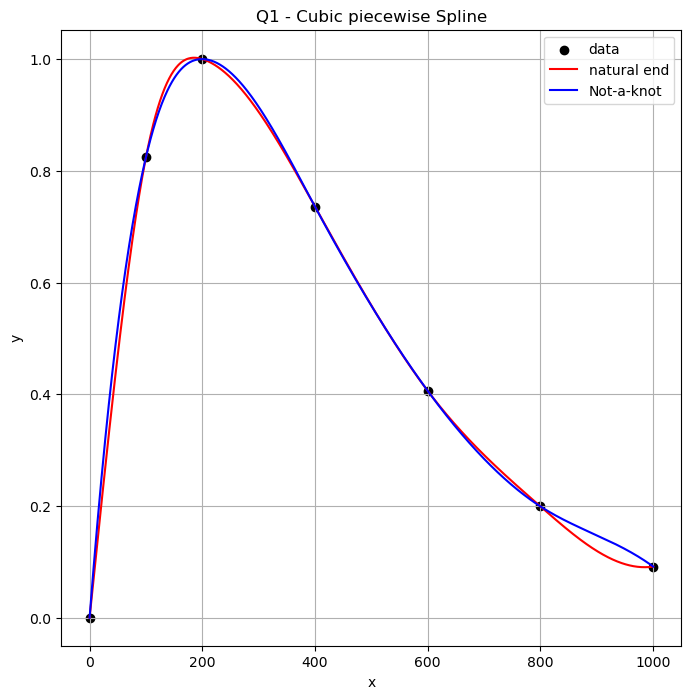

In [16]:
q1_x = np.linspace(q1_data['x'][0], q1_data['x'][-1], 1000)
q1_a_y = np.array([piecewise_spline(x, q1_a_sol_s) for x in q1_x])
q1_b_y = np.array([piecewise_spline(x, q1_b_sol_s) for x in q1_x])
plt.figure(figsize=(8,8))
plt.scatter(q1_data['x'], q1_data['y'], color='black', label='data')
plt.plot(q1_x, q1_a_y, label='natural end', color='red')
plt.plot(q1_x, q1_b_y, label='Not-a-knot', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Q1 - Cubic piecewise Spline')
plt.grid()
plt.legend()
plt.show()

---
# Q2: Finite Difference Method for PDE.

Solve the steady-state temperature distribution of a square heated plate using Liebmann’s
method with relaxation.

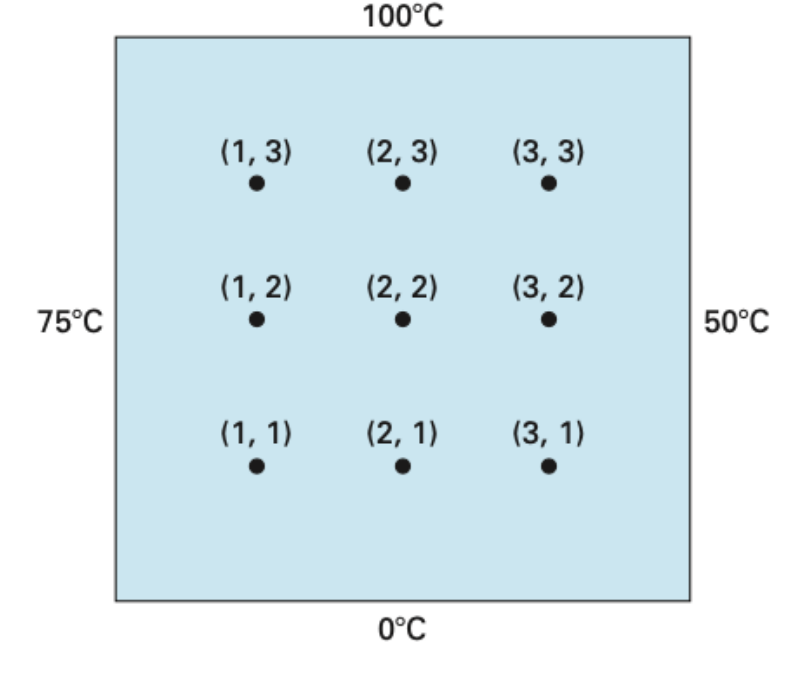

- Refer to the square plate described in your textbook (similar to Fig. 29.4).
- Modifications:
  - Upper boundary temperature = 150°C (modified).
  - Left boundary is insulated (zero-flux Neumann boundary).
  - Other boundaries remain as originally stated (adapt as needed).
- Use a relaxation factor of 1.2.
- Iterate until the relative error is ≤ 1%.

Question:
1. Set up the finite difference grid and equations. (3x3) and (5x5)
2. Apply Liebmann’s method to solve for the temperature at each grid point.
3. Implement your code using MATLAB or Python.
4. Plot: A 2D contour plot of the temperature distribution.
5. Discuss: The effect of using a relaxation factor. How the insulation at the left boundary affects the solution. How convergence was checked.


In [30]:
q2_data=dict(
    upper_boundary = 120,
    # left_boundary = 0, # insulated
    right_boundary = 50,
    bottom_boundary = 0,
    r = 1.2,
    rel_error = 1, #%
)

## Solution
### Set up the finite difference grid and equations. (3x3) and (5x5)
Let $T_{i,j}$ be the temperature on location $(i,j)$ Liebmann's method formula:
$$T_{i,j} = \frac{T_{i+1,j}+T_{i-1,j}+T_{i,j+1}+T_{i,j-1}}{4}$$

Left boundary condition is  insulated (zero-flux) which means no change in temperature, thus:
$$
T_{0,j} = T_{2,j} \forall j \in [1,3]
$$
The rest of boundary conditions are fixed as follows:
$$
\begin{align}
    T_{i,4} &= 120 &\text{ Top boundary}\\
    T_{i,0} &= 0 &\text{ Bottom boundary}\\
    T_{4,j} &= 50 &\text{ Right boundary}\\
\end{align}
$$
The Unknowns are $T_{i,j} \forall i \in [1,3], j \in [1,3]$ totaling of 9 unknowns.

In [31]:
from itertools import product

t = {}

# assign unknown variables
for i,j in product(range(1,4), repeat=2):
    t[(i,j)] = sp.Symbol(f'T{i}{j}')

for k in range(1,4):
    # Top boundary
    t[(k,4)] = sp.Integer(150)
    # bottom boundary
    t[(k,0)] = sp.Integer(0)
    # right boundary
    t[4,k] = sp.Integer(50)
    # left boundary T_{0,j} = T_{2,j}
    t[0,k] = t[2,k]

print(f'Grid layout:')
for j in range(5-1, -1, -1):
    for i in range(5):
        if (i, j) in t:
            print(t[(i, j)], end='\t')
        else:
            print('', end='\t')
    print()

Grid layout:
	150	150	150		
T23	T13	T23	T33	50	
T22	T12	T22	T32	50	
T21	T11	T21	T31	50	
	0	0	0		


### Apply Liebmann’s method to solve for the temperature at each grid point.


In [43]:
# Liebmann's method formula
q2_eqs = pd.Series()
for i,j in product(range(1,4), repeat=2):
    q2_eqs[f'T{i}{j}'] = (t[(i+1, j)] + t[(i-1, j)]+ t[(i, j+1)] + t[(i, j-1)])* sp.Rational(1,4)
    display(Math(f'T_{{{i},{j}}}(T^{{old}}_{{i,j}})={sp.latex(q2_eqs[f'T{i}{j}'])}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In each iteration we apply get new values $f(T^{old}_{i,j})$ and apply relaxation factor as follows:
$$
T^{new}_{i,j} = \lambda f(T^{old}_{i,j}) + (1-\lambda) T^{old}_{i,j}
$$

In [33]:
# initial condition
t_old = pd.Series({k:0 for k in q2_eqs.index})
# iterations
max_iterations = 100
lambda_r = q2_data['r']
q2_iterations=pd.DataFrame(columns=list(t_old.index) + ['rel_error'])
q2_iterations.loc[0] = pd.Series({**t_old.to_dict(), 'rel_error': 100})

def relative_error(*,old_values: pd.Series, new_values: pd.Series) -> float:
    if not old_values[old_values==0].empty:
        return 100
    diff = old_values - new_values
    rel_error = diff.abs() * 100 / old_values.abs()
    return round(rel_error.max(), 3)

for i in range(1, max_iterations + 1):
    # Liebmann's formulas
    t_new = q2_eqs.apply(lambda _: _.subs(t_old.copy().to_dict()).evalf())
    # apply over-relaxation
    # t_new = lambda_r * t_new + (1-lambda_r) * t_old.copy()
    rel = relative_error(old_values=t_old,new_values=t_new)
    q2_iterations.loc[i] = pd.Series({**t_new.to_dict(), 'rel_error': rel})
    if rel < q2_data['rel_error']:
        break
    t_old = t_new
display(Markdown(q2_iterations.to_markdown()))

|    |      T11 |     T12 |      T13 |      T21 |     T22 |      T23 |     T31 |     T32 |     T33 |   rel_error |
|---:|---------:|--------:|---------:|---------:|--------:|---------:|--------:|--------:|--------:|------------:|
|  0 |  0       |  0      |   0      |  0       |  0      |   0      |  0      |  0      |  0      |   100       |
|  1 |  0       |  0      |  37.5    |  0       |  0      |  37.5    | 12.5    | 12.5    | 50      |   100       |
|  2 |  0       |  9.375  |  56.25   |  3.125   | 12.5    |  59.375  | 15.625  | 28.125  | 62.5    |   100       |
|  3 |  3.90625 | 20.3125 |  69.5312 |  7.03125 | 25      |  70.3125 | 20.3125 | 35.1562 | 71.875  |   100       |
|  4 |  8.59375 | 30.8594 |  77.7344 | 12.3047  | 33.2031 |  79.1016 | 23.0469 | 41.7969 | 76.3672 |   120       |
|  5 | 13.8672  | 38.1836 |  84.7656 | 16.2109  | 41.0156 |  84.3262 | 26.0254 | 45.6543 | 80.2246 |    61.364   |
|  6 | 17.6514  | 45.166  |  89.209  | 20.2271  | 46.0938 |  89.0015 | 27.9663 | 49.3164 | 82.4951 |    27.289   |
|  7 | 21.405   | 49.762  |  93.2922 | 22.9279  | 50.9277 |  91.9495 | 29.8859 | 51.6388 | 84.5795 |    21.266   |
|  8 | 23.9044  | 54.1382 |  95.9152 | 25.5547  | 54.0695 |  94.6999 | 31.1417 | 53.8483 | 85.8971 |    11.677   |
|  9 | 26.3119  | 56.9897 |  98.3845 | 27.2789  | 57.0602 |  96.4705 | 32.3507 | 55.2771 | 87.137  |    10.071   |
| 10 | 27.8869  | 59.7042 |  99.9826 | 28.9307  | 59.004  |  98.1454 | 33.139  | 56.637  | 87.9369 |     6.05499 |
| 11 | 29.3914  | 61.4694 | 101.499  | 30.0075  | 60.8543 |  99.2309 | 33.8919 | 57.52   | 88.6956 |     5.39502 |
| 12 | 30.3711  | 63.1497 | 102.483  | 31.0344  | 62.0569 | 100.262  | 34.3819 | 58.3605 | 89.1877 |     3.422   |
| 13 | 31.3046  | 64.2419 | 103.419  | 31.7025  | 63.2017 | 100.932  | 34.8487 | 58.9066 | 89.6557 |     3.07401 |
| 14 | 31.9117  | 65.2816 | 104.026  | 32.3388  | 63.9457 | 101.569  | 35.1523 | 59.4265 | 89.9596 |     2.00699 |
| 15 | 32.4898  | 65.9574 | 104.605  | 32.7524  | 64.654  | 101.983  | 35.4413 | 59.7644 | 90.2489 |     1.811   |
| 16 | 32.8656  | 66.6007 | 104.981  | 33.1463  | 65.1143 | 102.377  | 35.6292 | 60.086  | 90.4368 |     1.202   |
| 17 | 33.2233  | 67.0187 | 105.339  | 33.4023  | 65.5525 | 102.633  | 35.8081 | 60.2951 | 90.6157 |     1.088   |
| 18 | 33.4558  | 67.4167 | 105.571  | 33.646   | 65.8373 | 102.877  | 35.9243 | 60.4941 | 90.732  |     0.72998 |

### Plot: A 2D contour plot of the temperature distribution.

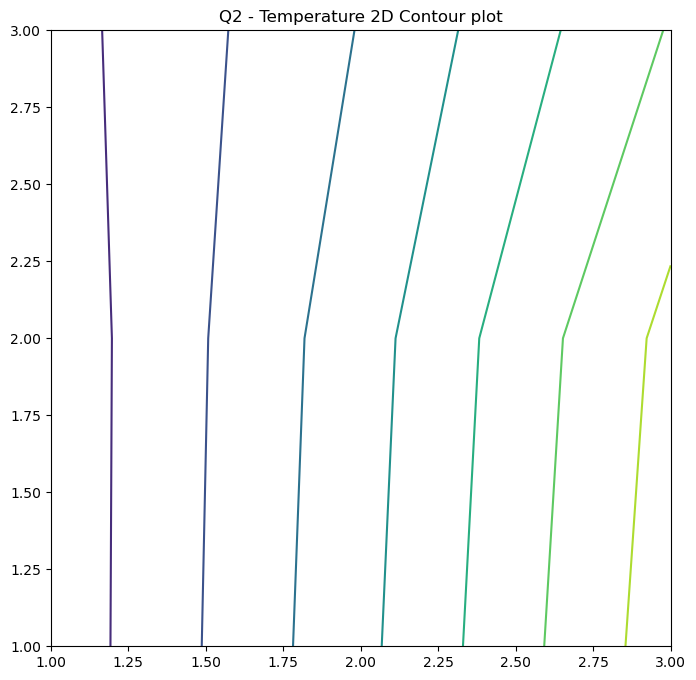

In [41]:
q2_sol = q2_iterations.loc[len(q2_iterations)-1]
q2_sol_2d = np.zeros((3,3))
for i,j in product(range(1,4), repeat=2):
    q2_sol_2d[i-1,j-1] = q2_sol.loc[f'T{i}{j}']

plt.figure(figsize=(8,8))
xy_mesh = np.meshgrid(range(1,4), range(1,4))
plt.contour(xy_mesh[0], xy_mesh[1], q2_sol_2d)
plt.title('Q2 - Temperature 2D Contour plot')
# plt.grid()
plt.show()

### Discuss: The effect of using a relaxation factor. How the insulation at the left boundary affects the solution. How convergence was checked.

Since the equation are diagonal (sparse matrix most entries are around the diagonal) the closer the relaxation factor to 1 the faster is the convergence where the relative error between the old and new iteration values are less than a predefined relative error (1% in our case).